Houses Competition
==

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

from scipy import stats

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, Lars
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from catboost import CatBoostRegressor, Pool

from sklearn.model_selection import GridSearchCV,RandomizedSearchCV,KFold,cross_val_score,train_test_split
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import StandardScaler

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


##### Dataset loading

In [2]:
#charging the dataset
house_filepath_train= "../input/house-prices-advanced-regression-techniques/train.csv"
house_filepath_test="../input/house-prices-advanced-regression-techniques/test.csv"

train=pd.read_csv(house_filepath_train,index_col='Id')
test=pd.read_csv(house_filepath_test,index_col='Id')

print(train.shape,test.shape)



# Remove rows with missing target, separate target from predictors
train.dropna(axis=0, subset=['SalePrice'], inplace=True)
y = train.SalePrice
Xtrain = train.copy()
test_index = test.index
train_index = train.index





(1460, 80) (1459, 79)


In [3]:
n_rows_train=Xtrain.shape[0]
Xall=pd.concat([Xtrain,test],axis=0)
Xall.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 80 columns):
1stFlrSF         2919 non-null int64
2ndFlrSF         2919 non-null int64
3SsnPorch        2919 non-null int64
Alley            198 non-null object
BedroomAbvGr     2919 non-null int64
BldgType         2919 non-null object
BsmtCond         2837 non-null object
BsmtExposure     2837 non-null object
BsmtFinSF1       2918 non-null float64
BsmtFinSF2       2918 non-null float64
BsmtFinType1     2840 non-null object
BsmtFinType2     2839 non-null object
BsmtFullBath     2917 non-null float64
BsmtHalfBath     2917 non-null float64
BsmtQual         2838 non-null object
BsmtUnfSF        2918 non-null float64
CentralAir       2919 non-null object
Condition1       2919 non-null object
Condition2       2919 non-null object
Electrical       2918 non-null object
EnclosedPorch    2919 non-null int64
ExterCond        2919 non-null object
ExterQual        2919 non-null object
Exterior1st      291

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


**Target Distribution**

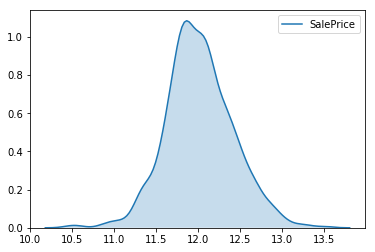

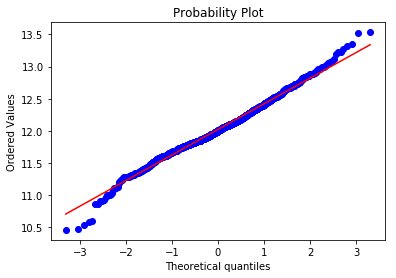

In [4]:
sns.kdeplot(data=np.log(y),shade=True)

fig=plt.figure()
res = stats.probplot(np.log(y), plot=plt)
plt.show()

The log houses prices approximate a normal distribution

#  I/ Pre-processing
 

## A/ Missing Values

The function below show the percentage of missings values in each features in the dataset

In [5]:
Xtrain

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500


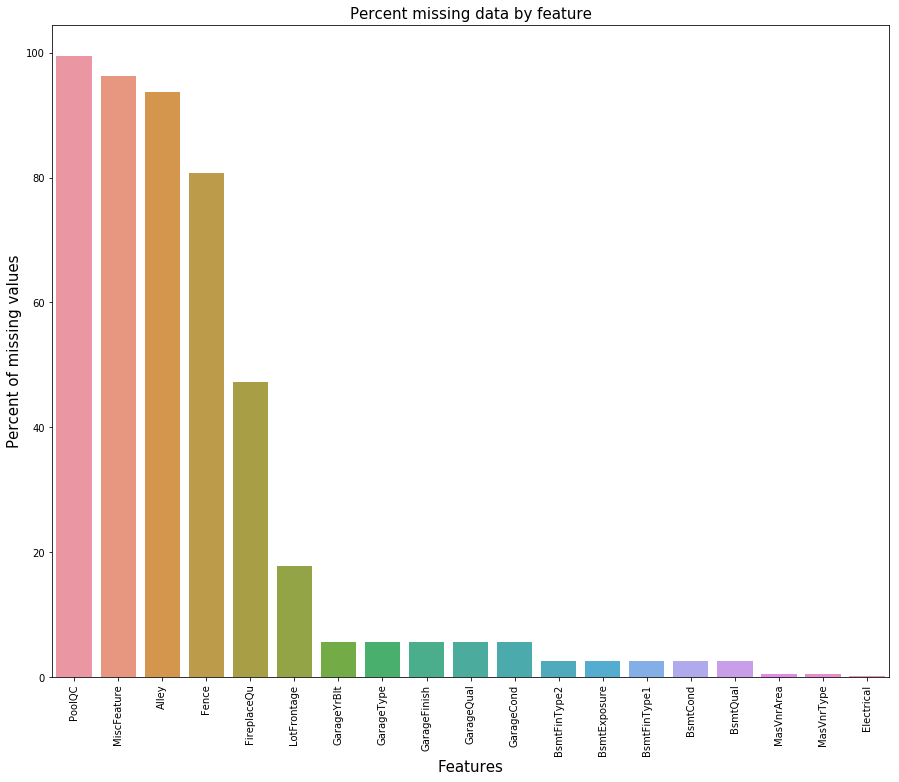

In [6]:
def missing_values_vizu(df):
    missing_by_col=df.isnull().sum()
    col_with_na=missing_by_col[missing_by_col>0]
    percent_missing=(col_with_na/len(df))*100
    percent_missing=percent_missing.sort_values(ascending=False)
    
    plt.figure(1, figsize=(15, 12))
    sns.barplot(x=percent_missing.index,y=percent_missing)

    plt.xticks(rotation='90')
    plt.xlabel('Features', fontsize=15)
    plt.ylabel('Percent of missing values', fontsize=15)
    plt.title('Percent missing data by feature', fontsize=15)

missing_values_vizu(Xtrain)
 

For some Features  NA is not a missing value but mean the absence of something in the house. This function below will replace NA in those columns by None

In [7]:
def replcaceNA_by_None(df,cols):
    for col in cols:
        df[col]=df[col].fillna('None')
    return df

In [8]:
subset=['Alley','BsmtQual','BsmtCond','BsmtExposure',
        'BsmtFinType1','BsmtFinType2','FireplaceQu',
        'GarageType','GarageFinish','GarageQual','GarageCond','PoolQC','Fence','MiscFeature']

Xtrain=replcaceNA_by_None(Xtrain,subset)
test = replcaceNA_by_None(test,subset)

In [9]:
missing_by_col=Xall.isnull().sum()
col_with_na=missing_by_col[missing_by_col>0]
col_with_na

Alley           2721
BsmtCond          82
BsmtExposure      82
BsmtFinSF1         1
BsmtFinSF2         1
BsmtFinType1      79
BsmtFinType2      80
BsmtFullBath       2
BsmtHalfBath       2
BsmtQual          81
BsmtUnfSF          1
Electrical         1
Exterior1st        1
Exterior2nd        1
Fence           2348
FireplaceQu     1420
Functional         2
GarageArea         1
GarageCars         1
GarageCond       159
GarageFinish     159
GarageQual       159
GarageType       157
GarageYrBlt      159
KitchenQual        1
LotFrontage      486
MSZoning           4
MasVnrArea        23
MasVnrType        24
MiscFeature     2814
PoolQC          2909
SalePrice       1459
SaleType           1
TotalBsmtSF        1
Utilities          2
dtype: int64

The function bellow will impute missings values with the mean for numericals variable and the most frequent value for categoricals variables

In [10]:
def imputeNA(df):
    #columns with missigns values
    cols_with_missings=[col for col in df.columns if df[col].isnull().any()]
    #numericals and categorials columns with missings values
    cols_num_with_missings=[col for col in df.loc[:,cols_with_missings].columns
                        if df[col].dtypes=='float64']
    cols_cat_with_missings=[col for col in df.loc[:,cols_with_missings].columns
                        if df[col].dtypes=='object']
    
    cat_subset=df.loc[:,cols_cat_with_missings]
    num_subset=df.loc[:,cols_num_with_missings]
    
    #mode imputationfor categorial columns
    for cat_col in cat_subset.columns:
        df[cat_col].fillna(df[cat_col].mode()[0],inplace=True)
        
    #mean imputaion in the numerical columns
    for col in num_subset.columns:
        df[col].fillna(df[col].mean(),inplace=True)
        
    return df

In [11]:
#need to change (split Test and train)
Xtrain["LotFrontage"] = Xtrain.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

test["LotFrontage"] = test.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))



Xtrain = imputeNA(Xtrain)
Xtrain.isnull().sum().sum()
test = imputeNA(test)
test.isnull().sum().sum()

0

**Correlation Matrix**

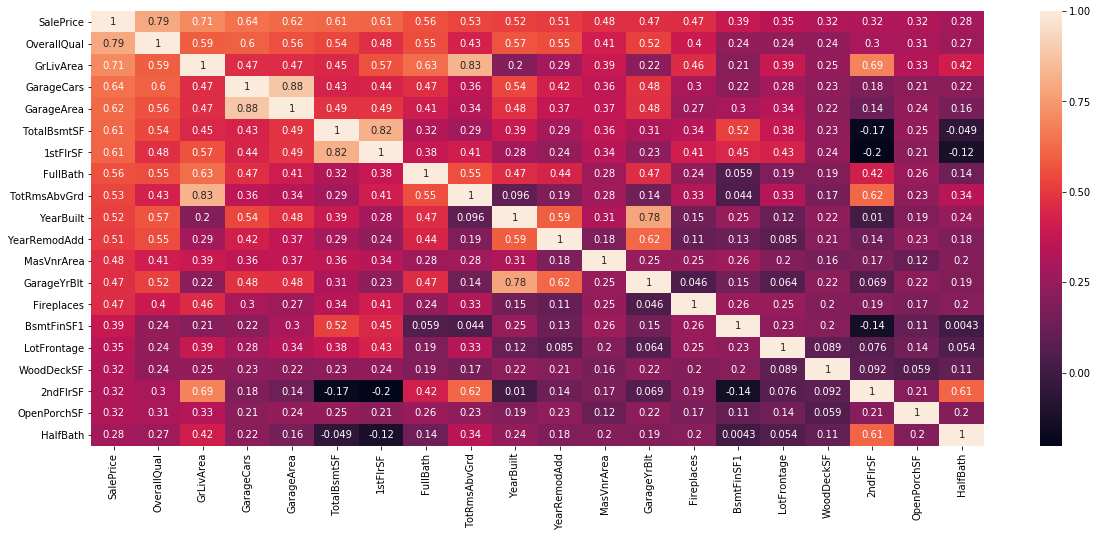

In [12]:
plt.figure(1, figsize=(20, 8))

#correlation matrix, take the 20 most correlated variables with SalePrice
corr=Xtrain.corr()
cols = corr.nlargest(20, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(Xtrain[cols].values.T)
sns.heatmap(cm,annot=True,yticklabels=cols.values,xticklabels=cols.values)

## B/ Features Engineering

In [13]:
def var_engine(df):

    df.drop('GarageArea',axis=1,inplace=True)

    df['HouseAge']= 2019 - df['YearBuilt']
    df['LastRemodeAge']= 2019- df['YearRemodAdd']
    df['GarageAge']= 2019 - df['GarageYrBlt']
    df['TotalHouseSF']= df['1stFlrSF'] + df['2ndFlrSF'] + df['TotalBsmtSF']
    df['NbrFloor']=np.where(df['2ndFlrSF']==0,1,2)
    df['TotRoms']= df['TotRmsAbvGrd'] + df['FullBath']

    df = df.drop(['GarageYrBlt','YearBuilt','YearRemodAdd'],axis=1)
    
    return df

Xtrain = var_engine(Xtrain)
test = var_engine(test)
    


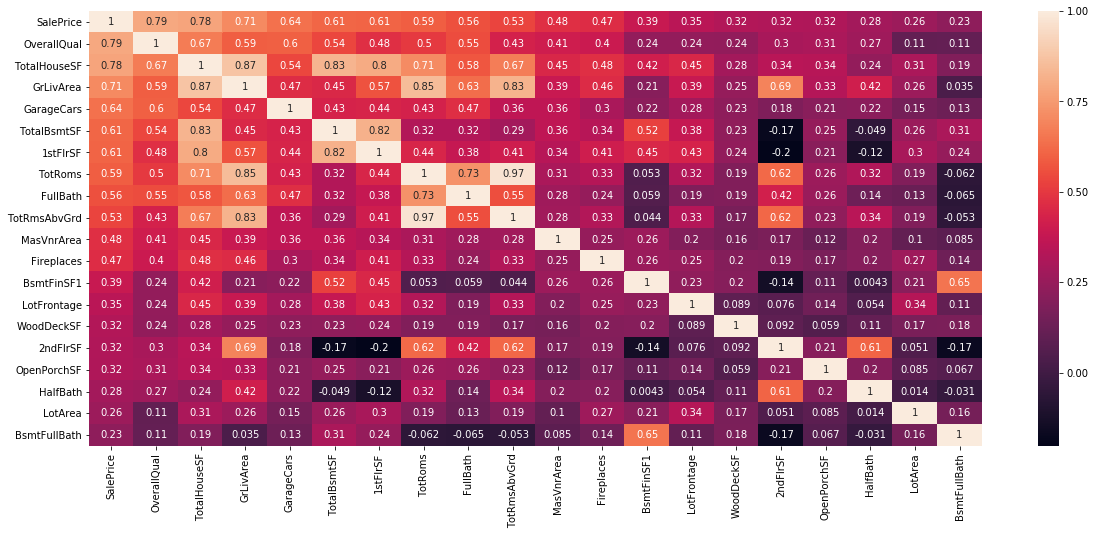

In [14]:
plt.figure(1, figsize=(20, 8))

#correlation matrix, take the 20 most correlated variables with SalePrice
corr=Xtrain.corr()
cols = corr.nlargest(20, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(Xtrain[cols].values.T)
sns.heatmap(cm,annot=True,yticklabels=cols.values,xticklabels=cols.values)



In [15]:
Xtrain = Xtrain.drop(['TotRmsAbvGrd','TotalBsmtSF','GrLivArea'],axis=1)
test = test.drop(['TotRmsAbvGrd','TotalBsmtSF','GrLivArea'],axis=1)

### Outliers 

/opt/conda/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/opt/conda/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


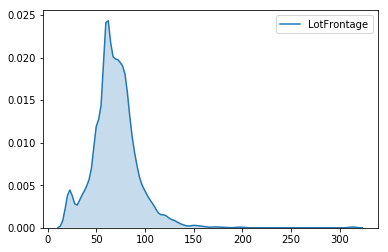

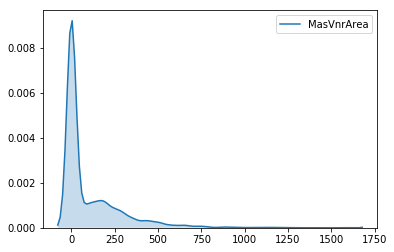

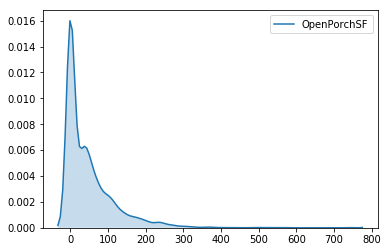

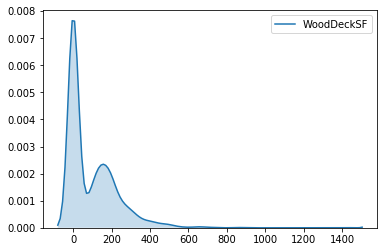

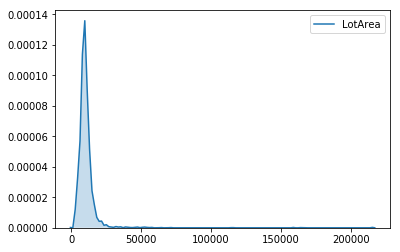

In [16]:
list_var = ["LotFrontage", "MasVnrArea", "OpenPorchSF","WoodDeckSF","LotArea"]
for var in list_var :
    sns.kdeplot(data = Xall[var],shade = True)
    plt.show()


In [17]:
def Features_discretization(df,cols,n_quantiles,labels):  
    df_copy=df.copy()
    for col in cols:
        df_copy=df_copy.drop(col,axis=1)
        df_copy[col]=pd.qcut(x=df[col],q=n_quantiles,duplicates='drop',labels=labels)
        
    return df_copy 



In [18]:
def replace_NA(Xall):

    Xall.LotShape.replace(to_replace = ['IR3', 'IR2', 'IR1', 'Reg'], value = [0, 1, 2, 3], inplace = True)
    Xall.Alley.replace(to_replace = ['None', 'Grvl', 'Pave'], value = [0, 1, 2], inplace = True)
    Xall.Street.replace(to_replace = ['Grvl', 'Pave'], value = [0, 1], inplace = True)
    Xall.ExterQual.replace(to_replace = ['Fa', 'TA', 'Gd', 'Ex'], value = [0, 1, 2, 3], inplace = True)
    Xall.ExterCond.replace(to_replace = ['Po', 'Fa', 'TA', 'Gd', 'Ex'], value = [0, 1, 2, 3, 4], inplace = True)
    Xall.BsmtQual.replace(to_replace = ['None','Fa', 'TA', 'Gd', 'Ex'], value = [0, 1, 2, 3,4],inplace = True)
    Xall.BsmtCond.replace(to_replace = ['None','Po', 'Fa', 'TA', 'Gd'], value = [0, 1, 2, 3,4], inplace = True)
    Xall.BsmtExposure.replace(to_replace = ['None','No', 'Mn', 'Av', 'Gd'], value = [0, 1, 2, 3,4], inplace = True)
    Xall.BsmtFinType1.replace(to_replace = ['None','Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'], value = [0, 1, 2, 3, 4, 5,6], inplace = True)
    Xall.BsmtFinType2.replace(to_replace = ['None','Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'], value = [0, 1, 2, 3, 4, 5,6], inplace = True)
    Xall.HeatingQC.replace(to_replace = ['Po', 'Fa', 'TA', 'Gd', 'Ex'], value = [0, 1, 2, 3, 4], inplace = True)
    Xall.CentralAir.replace(to_replace = ['N', 'Y'], value = [0, 1], inplace = True)
    Xall.Electrical.replace(to_replace = ['Mix', 'FuseP', 'FuseF', 'FuseA', 'SBrkr'], value = [0, 1, 2, 3, 4], inplace = True)
    Xall.KitchenQual.replace(to_replace = ['Fa', 'TA', 'Gd', 'Ex'], value = [0, 1, 2, 3], inplace = True)
    Xall.Functional.replace(to_replace = ['Sal','Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ'], value = [0, 1, 2, 3, 4, 5, 6,7], inplace = True)
    Xall.GarageFinish.replace(to_replace = ['None','Unf', 'RFn', 'Fin'], value = [0, 1, 2,3], inplace = True)
    Xall.GarageQual.replace(to_replace =  ['None','Po', 'Fa', 'TA', 'Gd', 'Ex'], value = [0, 1, 2, 3, 4,5], inplace = True)
    Xall.GarageCond.replace(to_replace =  ['None','Po', 'Fa', 'TA', 'Gd', 'Ex'], value = [0, 1, 2, 3, 4,5], inplace = True)
    Xall.PavedDrive.replace(to_replace =  ['N', 'P', 'Y'], value = [0, 1, 2], inplace = True)
    Xall.PoolQC.replace(to_replace =  ['None', 'Fa','TA', 'Gd', 'Ex'], value = [0, 1, 2,3,4], inplace = True)
    Xall.Fence.replace(to_replace =  ['None', 'MnWw', 'GdWo', 'MnPrv', 'GdPrv'], value = [0, 1, 2,3,4], inplace = True)
    Xall.FireplaceQu.replace(to_replace =  ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'], value = [0, 1, 2,3,4,5], inplace = True)


    return Xall

Xtrain=replace_NA(Xtrain)
test = replace_NA(test)


## Outliers

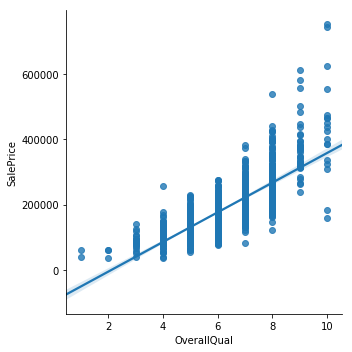

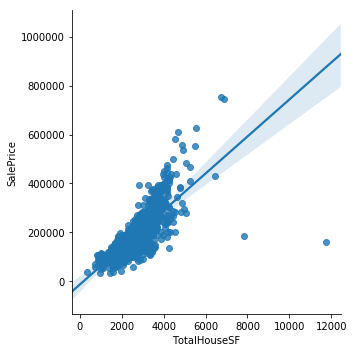

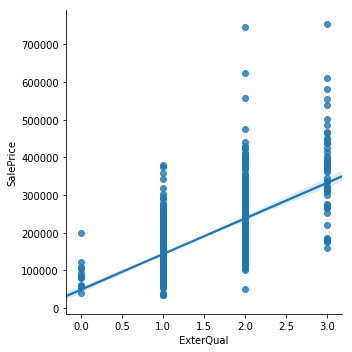

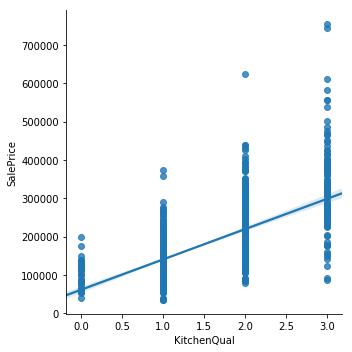

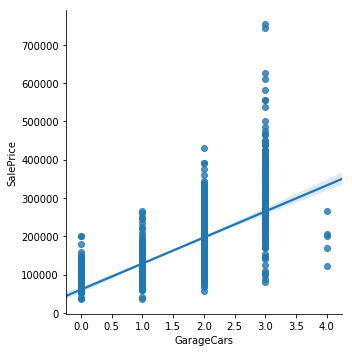

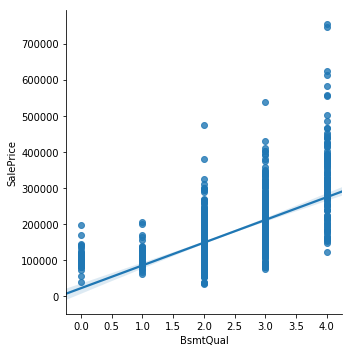

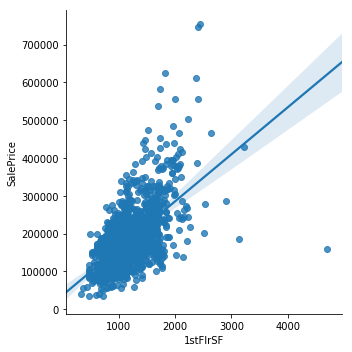

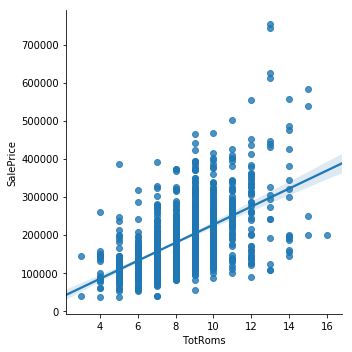

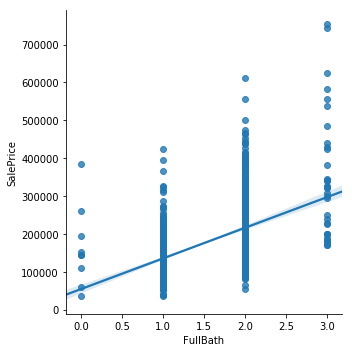

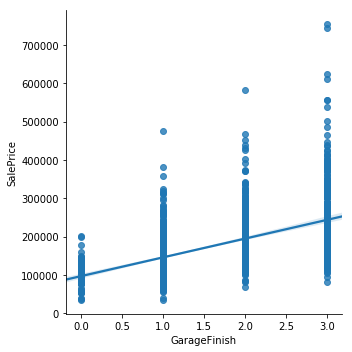

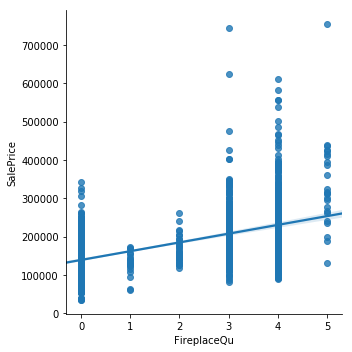

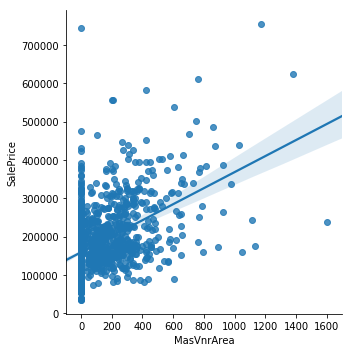

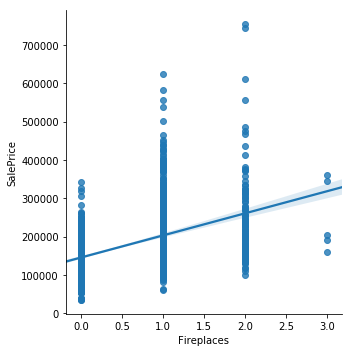

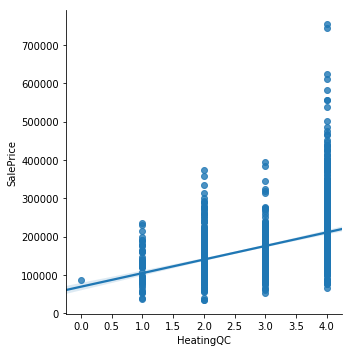

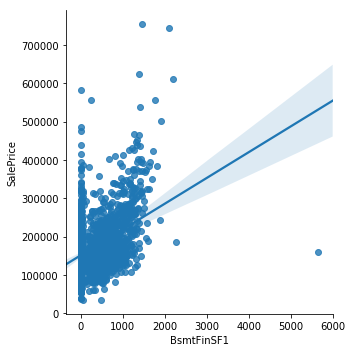

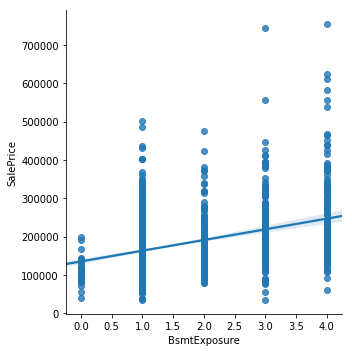

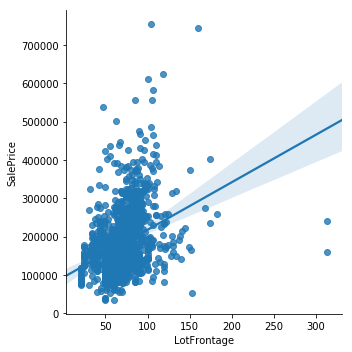

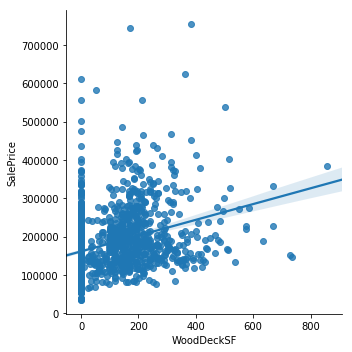

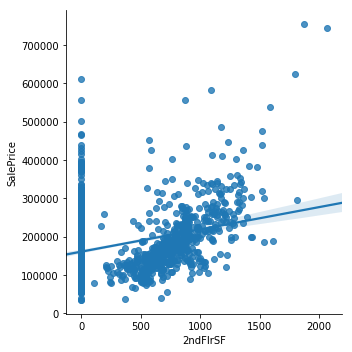

In [19]:
corr=Xtrain.corr()
cols = corr.nlargest(20, 'SalePrice')['SalePrice'].index
for col in cols[1:] :
    sns.lmplot(x=col,y='SalePrice',data=Xtrain)

In [20]:
"""
def drop_outlier(data):
    
    df = data.copy()
    index_to_drop1=df[df.TotalHouseSF>7500].index
    df.drop(index_to_drop1,inplace=True)
    
    index_to_drop2=df[df.LotFrontage>300].index
    df.drop(index_to_drop2,inplace=True)

    index_to_drop3=df[df.MasVnrArea>1500].index
    df.drop(index_to_drop3,inplace=True)

    print("the number of points deleted is:", data.shape[0] - df.shape[0])
    
    return df

Xtrain = drop_outlier(Xtrain)
print(Xtrain.shape)

"""

'\ndef drop_outlier(data):\n    \n    df = data.copy()\n    index_to_drop1=df[df.TotalHouseSF>7500].index\n    df.drop(index_to_drop1,inplace=True)\n    \n    index_to_drop2=df[df.LotFrontage>300].index\n    df.drop(index_to_drop2,inplace=True)\n\n    index_to_drop3=df[df.MasVnrArea>1500].index\n    df.drop(index_to_drop3,inplace=True)\n\n    print("the number of points deleted is:", data.shape[0] - df.shape[0])\n    \n    return df\n\nXtrain = drop_outlier(Xtrain)\nprint(Xtrain.shape)\n\n'

## C/ Features encoding <br/>
Firtly I'm going to encode the hiarachicals variables in a way that respect their order. In order to do so we need to concatenate the training and the test dataset because some features may not have the same modalities in differents datasets. Then I'm going to one-hot-encode the other variables by creating a function using the instruction 'get_dummies'.

In [21]:
def OneHotEncod(df,cols):
    for col in cols:
        dummy=pd.get_dummies(df[col],prefix=col) # dataFrame of dummies for each modality of the variable
        df=df.drop(col,axis=1) #drop the former variable
        df=pd.concat([df,dummy],axis=1) #put the dummies in the dataFrame
    return df

In [22]:
cols_to_onehotEncod=['MSZoning','Neighborhood','LandContour','Utilities','Condition1','LotConfig',
                        'BldgType','HouseStyle','RoofMatl','MasVnrType','Foundation',
                     'Heating','Functional','MiscFeature',
                     'RoofStyle','Exterior1st','GarageType','SaleType', 'SaleCondition','LandSlope']

X_forCatB = Xtrain.copy()
#test_forCatB = test.copy()


Xall = pd.concat([Xtrain,test],axis = 0)

Xall = OneHotEncod(Xall,cols_to_onehotEncod)
Xtrain = Xall.loc[train_index,:]
test = Xall.loc[test_index,:]



/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  # Remove the CWD from sys.path while we load stuff.


In [23]:
Xtrain

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,...,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev
Id,,,,,,,,,,,,,,,,,,,,,
1,856,854,0,0,3,3,1,706.0,0.0,6,...,1,0,0,0,0,1,0,1,0,0
2,1262,0,0,0,3,3,4,978.0,0.0,5,...,1,0,0,0,0,1,0,1,0,0
3,920,866,0,0,3,3,2,486.0,0.0,6,...,1,0,0,0,0,1,0,1,0,0
4,961,756,0,0,3,4,1,216.0,0.0,5,...,1,1,0,0,0,0,0,1,0,0
5,1145,1053,0,0,4,3,3,655.0,0.0,6,...,1,0,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,953,694,0,0,3,3,1,0.0,0.0,1,...,1,0,0,0,0,1,0,1,0,0
1457,2073,0,0,0,3,3,1,790.0,163.0,5,...,1,0,0,0,0,1,0,1,0,0
1458,1188,1152,0,0,4,4,1,275.0,0.0,6,...,1,0,0,0,0,1,0,1,0,0


In [24]:
test

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,...,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev
Id,,,,,,,,,,,,,,,,,,,,,
1461,896,0,0,0,2,3,1,468.0,144.0,3,...,1,0,0,0,0,1,0,1,0,0
1462,1329,0,0,0,3,3,1,923.0,0.0,5,...,1,0,0,0,0,1,0,1,0,0
1463,928,701,0,0,3,3,1,791.0,0.0,6,...,1,0,0,0,0,1,0,1,0,0
1464,926,678,0,0,3,3,1,602.0,0.0,6,...,1,0,0,0,0,1,0,1,0,0
1465,1280,0,0,0,2,3,1,263.0,0.0,5,...,1,0,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2915,546,546,0,0,3,3,1,0.0,0.0,1,...,1,0,0,0,0,1,0,1,0,0
2916,546,546,0,0,3,3,1,252.0,0.0,3,...,1,1,0,0,0,0,0,1,0,0
2917,1224,0,0,0,4,3,1,1224.0,0.0,5,...,1,1,0,0,0,0,0,1,0,0


In [25]:
cat_cols=[col for col in Xtrain.columns
                        if Xtrain[col].dtypes=='object']

Xtrain.drop(cat_cols,axis=1,inplace=True)
test.drop(cat_cols,axis=1,inplace=True)



In [26]:
test.dtypes

1stFlrSF                 int64
2ndFlrSF                 int64
3SsnPorch                int64
Alley                    int64
BedroomAbvGr             int64
                         ...  
SaleCondition_Normal     uint8
SaleCondition_Partial    uint8
LandSlope_Gtl            uint8
LandSlope_Mod            uint8
LandSlope_Sev            uint8
Length: 201, dtype: object

# II/ Modeling

In [27]:
seed=44

## Simples models

In [28]:
def modelScore_lin(X_train,X_valid,y_train,y_valid,models_list):
    score_list=[]
    label=[]
    for model in models_list:
        model.fit(X_train,y_train)
        score = np.sqrt(mean_squared_error(np.exp(y_valid),np.exp(model.predict(X_valid))))
        score_list.append(score)
    return score_list

def modelScore(X_train,X_valid,y_train,y_valid,models_list):
    score_list=[]
    label=[]
    for model in models_list:
        model.fit(X_train,y_train)
        score = np.sqrt(mean_squared_error(y_valid,model.predict(X_valid)))
        score_list.append(score)
    return score_list

## Linear model

In [29]:
y = Xtrain.SalePrice
Xtrain = Xtrain.drop('SalePrice',axis=1)
logy=np.log(y)

X_train,X_valid,y_train,y_valid = train_test_split(Xtrain,logy,test_size = 0.2,random_state = seed)

In [30]:
lr = LinearRegression()
lasso = Lasso(alpha = 0.1)
ridge = Ridge(alpha = 0.1)
elnt = ElasticNet(alpha = 5, l1_ratio = 0.5)


models_list=[lr,lasso,ridge,elnt]

## Ensemble Model

In [31]:
X_train2,X_valid2,y_train2,y_valid2 = train_test_split(Xtrain,y,test_size = 0.2,random_state = seed)

In [32]:
Rfor = RandomForestRegressor(
                        n_estimators = 200,
                        max_depth = 6,
                        min_samples_leaf = 2,
                        )
GB = GradientBoostingRegressor(
                        n_estimators = 200,
                        learning_rate = 1,
                        max_depth = 6,
                        min_samples_leaf = 2)

model_list2 = [Rfor,GB]

In [33]:
models_labels=['LinearReg','Lasso','Ridge','elastic net',"Random_Forest","Gradient_Boosting"]

score_list_lin=modelScore_lin(X_train,X_valid,y_train,y_valid,models_list)
score_list_en=modelScore(X_train2,X_valid2,y_train2,y_valid2,model_list2)
score_list = score_list_lin + score_list_en

result_train=pd.DataFrame(data=[score_list],columns=models_labels,index=['Score'])
result_train

,LinearReg,Lasso,Ridge,elastic net,Random_Forest,Gradient_Boosting
Score,21003.126144,31555.85967,21024.9381,38360.654812,29584.621961,38014.889308


Text(0.5, 1.0, 'Score by model')

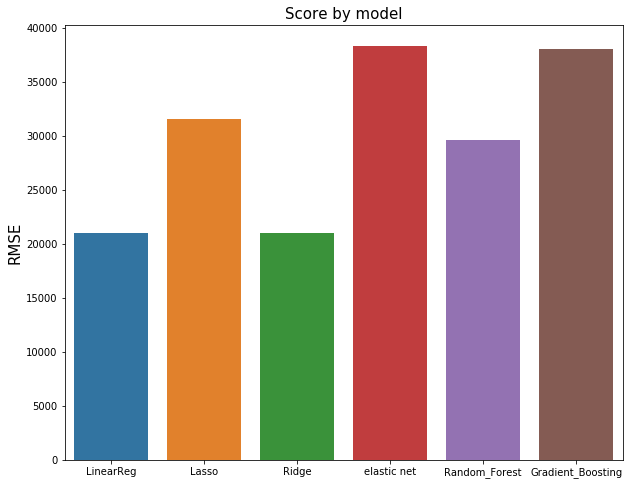

In [34]:
plt.figure(1, figsize=(10, 8))
sns.barplot(x=result_train.columns,y=score_list)

plt.ylabel('RMSE', fontsize=15)
plt.title('Score by model', fontsize=15)

## XGBoost

In [35]:
XGB = xgb.XGBRegressor(
            objective='reg:squarederror',
            eta = 1,
            gamma = 1,
            max_deph = 6,
            reg_lambda = 2,
            subsample  = 0.8,
            eval_metric = 'rmse',
            )

XGB.fit(X_train2,y_train2)
score_xgb = np.sqrt(mean_squared_error(y_valid2,XGB.predict(X_valid2)))

print(score_xgb)

/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


27497.095836237688


In [36]:
X_train.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,...,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev
Id,,,,,,,,,,,,,,,,,,,,,
398,876,936,0,0,4,3,1,540.0,0.0,5,...,1,0,0,0,0,1,0,1,0,0
982,1276,1336,0,0,4,3,1,854.0,0.0,6,...,1,0,0,0,0,1,0,1,0,0
219,1137,817,0,0,3,3,1,341.0,0.0,4,...,1,0,0,0,0,1,0,1,0,0
917,480,0,0,0,1,3,3,50.0,0.0,4,...,1,1,0,0,0,0,0,1,0,0
658,851,651,0,0,3,3,1,0.0,0.0,1,...,1,0,0,0,0,1,0,0,1,0


## CatBoost

In [37]:
#y = X_forCatB.SalesPrice
#XtrainB = X_forCatB.drop(["SalesPrice"],axis = 1)

X_train,X_valid,y_train,y_valid = train_test_split(X_forCatB,y,test_size = 0.2,random_state = seed)


cat_feat = cols_to_onehotEncod + cat_cols
cat_num = X_forCatB.columns.get_indexer(cat_feat)
train_pool = Pool(X_train,y_train,cat_features = cat_num)
valid_pool =  Pool(X_valid,y_valid,cat_features = cat_num)

In [38]:
CatB = CatBoostRegressor(
            iterations = 2000,
            learning_rate = 0.1,
            max_depth = 6,
#            subsample = 0.8,
            loss_function='RMSE',
#            min_child_samples = 2,
            one_hot_max_size = 6,
#            langevin = False,
            )

CatB.fit(train_pool,
    #cat_features = cat_num
    eval_set = valid_pool,
    use_best_model = True,
    early_stopping_rounds = 50,
    verbose = 50)

0:	learn: 75396.9771376	test: 70741.5389214	best: 70741.5389214 (0)	total: 86.5ms	remaining: 2m 52s
50:	learn: 29625.4296658	test: 26167.1318800	best: 26167.1318800 (50)	total: 739ms	remaining: 28.2s
100:	learn: 16279.7164429	test: 17083.4919671	best: 17083.4919671 (100)	total: 1.84s	remaining: 34.6s
150:	learn: 12486.4049551	test: 14369.7733286	best: 14369.7733286 (150)	total: 3.14s	remaining: 38.5s
200:	learn: 11325.8443281	test: 13702.6189452	best: 13702.6189452 (200)	total: 4.39s	remaining: 39.3s
250:	learn: 10797.0856670	test: 13576.3583442	best: 13576.3583442 (250)	total: 5.63s	remaining: 39.3s
300:	learn: 9950.0644417	test: 13074.3069951	best: 13071.7950550 (299)	total: 6.89s	remaining: 38.9s
350:	learn: 9597.5214917	test: 12934.6554839	best: 12934.6554839 (350)	total: 8.12s	remaining: 38.1s
400:	learn: 9355.1951436	test: 12809.5203281	best: 12809.5203281 (400)	total: 9.36s	remaining: 37.3s
450:	learn: 9241.8371065	test: 12787.5524792	best: 12783.2746591 (429)	total: 10.6s	remai

## Parameters Optimisation

In [39]:
def grid_parameters_optimization(df,target,model,parameters_dict,score_type,n_fold):
    
    grid_search=GridSearchCV(estimator = model,
                             param_grid = parameters_dict,
                             cv = n_fold,
                             n_jobs = -1,
                             scoring = score_type
                            )
    grid_search.fit(df,target)
    best_score=grid_search.best_score_
    best_parameter=grid_search.best_params_
    
    return best_score,best_parameter


def random_parameters_optimization(df,target,model,parameters_dict,score_type,n_fold):
    
    grid_search=RandomizedSearchCV(estimator = model,
                               param_distributions = parameters_dict,
                               cv = n_fold,
                               n_jobs = -1,
                               scoring = score_type)
    grid_search.fit(df,target)
    best_score=grid_search.best_score_
    best_parameter=grid_search.best_params_
    
    return best_score,best_parameter





def param_optimisation(df,target,model,parameters_grid,score_type,opti_type,n_fold):
    if opti_type == "grid":
        best_score,best_parameter = grid_parameters_optimization(df,target,model,parameters_grid,score_type,n_fold)
    if opti_type == "random":
        best_score,best_parameter = random_parameters_optimization(df,target,model,parameters_grid,score_type,n_fold)
        
    return best_score,best_parameter

In [40]:
ridge_grid={'alpha':[0.1,0.5,1,2,3,5,7,10,20]}
rid=Ridge(random_state=seed)
ridge_opti=param_optimisation(Xtrain,y,rid,ridge_grid,'neg_mean_squared_error',"random",5)

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:266: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


In [41]:
ridge_opti

(-1055654316.7566042, {'alpha': 5})

In [42]:
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt import gp_minimize

n_features = Xtrain.shape[1]

xg = xgb.XGBRegressor(
            objective='reg:squarederror',
            reg_lambda = 2,
            subsample  = 0.8,
            eval_metric = 'rmse',
            )


space  = [Integer(1, 5, name='max_depth'),
          Integer(50, 1000,name = 'n_estimators'),
          Real(10**-5, 10**0,"log-uniform", name ='learning_rate'),
          Integer(1, n_features, name='max_features'),
          Integer(2, 100, name='min_samples_split'),
          Integer(1, 100, name='min_samples_leaf')]

@use_named_args(space)
def objective(**params):
    return -np.mean(cross_val_score(xg,Xtrain,y,cv = 5,n_jobs = -1,
                                   scoring = "neg_mean_squared_error"))


res_gp = gp_minimize(objective, space, n_calls=50, random_state=0)

"Best score=%.4f" % res_gp.fun

/opt/conda/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


'Best score=719356822.6821'

In [43]:
print("""Best parameters:
- max_depth = %d
- n_estimators = %d
- learning_rate=%.6f
- max_features=%d
- min_samples_split=%d
- min_samples_leaf=%d""" % (res_gp.x[0], res_gp.x[1],
                            res_gp.x[2], res_gp.x[3],
                            res_gp.x[4],res_gp.x[5]))

Best parameters:
- max_depth = 3
- n_estimators = 852
- learning_rate=0.194862
- max_features=170
- min_samples_split=63
- min_samples_leaf=39


In [44]:
xgb_opti = xgb.XGBRegressor(
            objective='reg:squarederror',
            reg_lambda = 2,
            subsample  = 0.8,
            eval_metric = 'rmse',
            max_depth = 3,
            n_estimators = 800,
            learnig_rate = 0.2,
            max_features = 170,
            min_samples_split = 63,
            min_samples_leaf = 39
            )

xgb_opti.fit(X_train2,y_train2,
            verbose = 50)
score_xgb = np.sqrt(mean_squared_error(y_valid2,xgb_opti.predict(X_valid2)))

print(score_xgb)

/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


26797.199024323963


### Focus on Ridge Model

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=9.83883e-22): result may not be accurate.
  overwrite_a=True).T
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.24229e-21): result may not be accurate.
  overwrite_a=True).T
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.56676e-21): result may not be accurate.
  overwrite_a=True).T
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.97619e-21): result may not be accurate.
  overwrite_a=True).T
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.49094e-21): result may not be accurate.
  overwrite_a=True).T
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarni

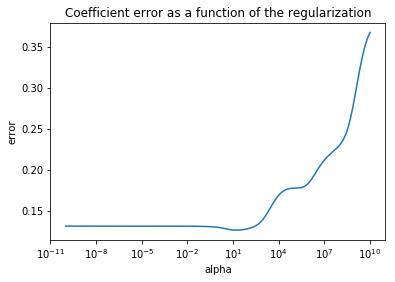

In [45]:
X_train,X_valid,y_train,y_valid = train_test_split(Xtrain,logy,test_size = 0.2,random_state = seed)

ridge = Ridge(
    random_state = seed,
    )

rsme = []
alphas =  np.logspace(-10, 10, 200)

for a in alphas:
    ridge.set_params(alpha=a)
    ridge.fit(X_train, y_train)
    rsme.append(np.sqrt(mean_squared_error(y_valid,ridge.predict(X_valid))))
    
    
ax = plt.gca()
ax.plot(alphas, rsme)
ax.set_xscale("log")
plt.xlabel("alpha")
plt.ylabel("error")
plt.title("Coefficient error as a function of the regularization")
plt.axis("tight")

plt.show()

Optimal number of features : 91


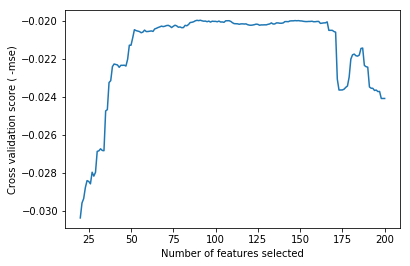

In [46]:
rid = Ridge(alpha = 5, random_state = seed )

min_features_to_select = 20  # Minimum number of features to consider
rfecv = RFECV(
    estimator=rid,
    step=1,
    cv=5,
    scoring="neg_mean_squared_error",
    min_features_to_select=min_features_to_select,
)
rfecv.fit(X_train, y_train)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score ( -mse)")
plt.plot(
    range(min_features_to_select, len(rfecv.grid_scores_) + min_features_to_select),
    rfecv.grid_scores_,
)
plt.show()

In [47]:
var_selected = X_train.loc[:,rfecv.support_].columns
Xtrain_selected = Xtrain.loc[:,var_selected]
X_train,X_valid,y_train,y_valid = train_test_split(Xtrain_selected,logy,test_size = 0.2,random_state = seed)

In [48]:
y_valid.shape

(292,)

In [49]:
ridge_best = Ridge(alpha = 5, random_state = seed)
ridge_best.fit(X_train,y_train)
score = np.sqrt(mean_squared_error(y_valid,ridge_best.predict(X_valid)))


In [50]:
print(score)

0.1446473099390842


## Submission 

In [51]:
test = test.loc[:,var_selected]

In [52]:
test.isna().sum()


Alley                    0
BsmtExposure             0
BsmtFullBath             0
BsmtHalfBath             0
BsmtQual                 0
                        ..
SaleCondition_Abnorml    0
SaleCondition_AdjLand    0
SaleCondition_Family     0
SaleCondition_Normal     0
LandSlope_Mod            0
Length: 91, dtype: int64

In [53]:
[c for c in test.columns if test[c].isna().sum() > 0]

[]

In [54]:
ridge=Ridge(alpha=5,random_state=seed)
ridge.fit(Xtrain_selected,logy)
prediction=ridge.predict(test)

test_ids=test.index
results=pd.DataFrame({'Id':test_ids,'SalePrice':np.exp(prediction)})
results

results.to_csv('submission.csv',index=False)


In [55]:
results

,Id,SalePrice
0,1461,117385.330823
1,1462,146869.575822
2,1463,154475.611002
3,1464,180101.517883
4,1465,195049.351720
...,...,...
1454,2915,81734.152764
1455,2916,83486.298795
1456,2917,153060.489694
1457,2918,112450.934976
